## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorboard
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
from keras import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D
from keras.losses import CategoricalCrossentropy
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix,classification_report
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Plot settings
ROWS = 5
COLS = 10


In [2]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
X_train_df = train_df.drop(["label"],axis=1)
y_train_df = train_df[["label"]]

X_train_df.shape

(42000, 784)

In [3]:
X_train = (X_train_df.values/255).reshape(-1,28,28,1) # Normalization
y_train = y_train_df.values

In [4]:
def get_sample(n,x,y):
    indexes = np.random.choice(len(x), replace = False, size = n)
    images = x[indexes]
    images = images
    labels = np.squeeze(y)
    labels = labels[indexes]
    return images,labels

## Visualizing Train Images

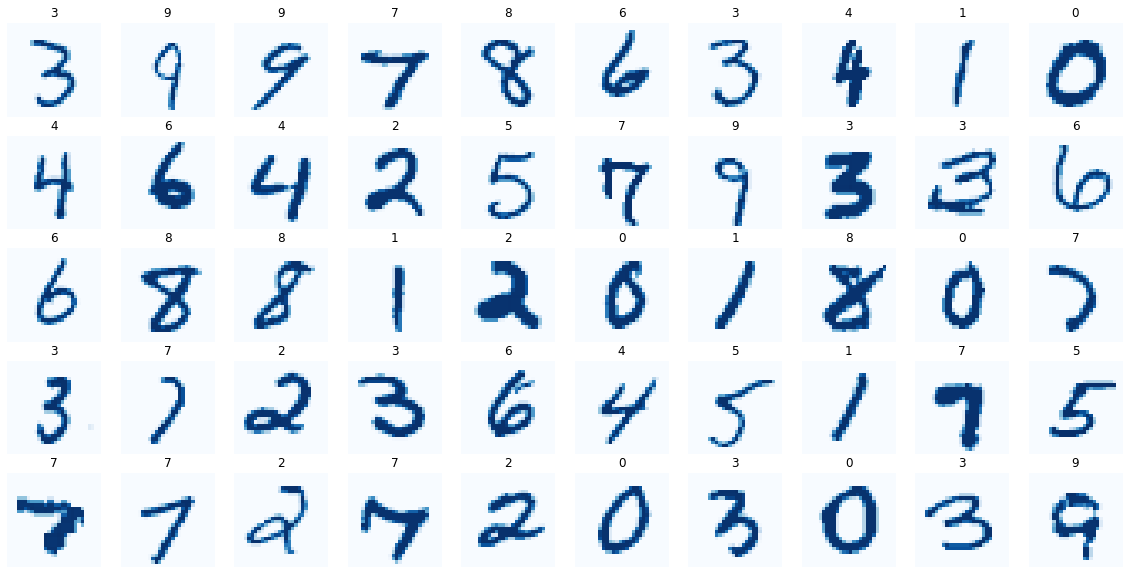

In [5]:
images, labels = get_sample(ROWS*COLS,X_train,y_train)
fig, ax = plt.subplots(ROWS,COLS, figsize=(COLS*2,ROWS*2))
for i, (image,label) in enumerate(zip(images,labels)):
    ax[i//COLS, i%COLS].axis('off')
    ax[i//COLS, i%COLS].set_title(label)
    ax[i//COLS, i%COLS].imshow(image, cmap="Blues")
plt.show()


## Split Train Dataset stratify to Train-Validation

In [6]:
# train_rate = 0.8, validation_rate = 0.2
skf = StratifiedKFold(n_splits=5,shuffle=True)

train_idxs, validation_idxs = next(skf.split(X_train,y_train))

# select train and validation data by their indexes
X_valid = X_train[validation_idxs]
y_valid = y_train[validation_idxs]
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]
print(f"""There are {y_train.shape[0]} samples in train part.
There are {X_valid.shape[0]} samples in validation part.
""")

There are 33600 samples in train part.
There are 8400 samples in validation part.



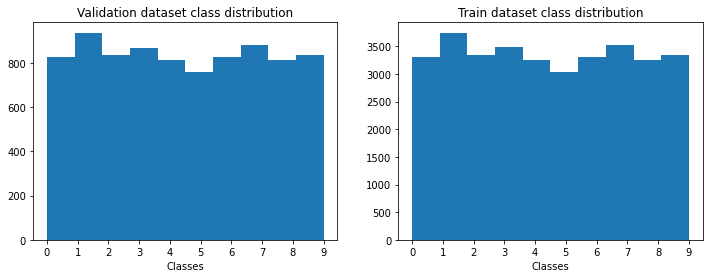

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(y_valid,bins=10)
ax[0].set_title("Validation dataset class distribution")
ax[0].set_xticks(range(0,10))
ax[0].set_xlabel("Classes")

ax[1].hist(y_train,bins=10)
ax[1].set_title("Train dataset class distribution")
ax[1].set_xticks(range(0,10))
ax[1].set_xlabel("Classes")

plt.show()

In [8]:
class CustomCheckpoint(Callback):

    def __init__(self):
        super(CustomCheckpoint, self).__init__()
        self.best_weights = None
        self.best = np.Inf
        
    def on_epoch_end(self,epoch, logs=None):
        current_loss = logs.get("val_loss")
        current_loss += logs.get("loss")
        if np.less(current_loss, self.best):
            self.best = current_loss
            # record the best weights if current loss is better (less).
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        # set best weights to final model
        self.model.set_weights(self.best_weights)


## Data Augmentation

In [9]:
data_generator = ImageDataGenerator(width_shift_range=0.1,\
                                   height_shift_range=0.1,\
                                   zoom_range=0.1,\
                                   rotation_range=0.1)
data_generator.fit(X_train)

## Model Architecture

In [10]:
def get_model():
    nn = Sequential()
    nn.add(Conv2D(64, (3,3),input_shape=(28,28,1), activation='relu'))
    nn.add(MaxPool2D((2,2)))
    nn.add(Conv2D(64, (3,3), activation='relu'))
    nn.add(Flatten())
    nn.add(Dense(128, activation='relu'))
    nn.add(Dense(64, activation='relu'))
    nn.add(Dense(10, activation='softmax'))
    nn.compile(loss=CategoricalCrossentropy(from_logits=False),
              optimizer="adam", metrics=["accuracy"])
    return nn

In [11]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               991360    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                6

In [12]:
model.fit(data_generator.flow(X_train,to_categorical(y_train),batch_size=64),steps_per_epoch=X_train.shape[0]//64\
                   ,epochs=100,callbacks=[CustomCheckpoint()],validation_data=(X_valid,to_categorical(y_valid)))

Epoch 1/100
525/525 [==============================] - 21s 25ms/step - loss: 0.3550 - accuracy: 0.8873 - val_loss: 0.0980 - val_accuracy: 0.9681
Epoch 2/100
525/525 [==============================] - 13s 24ms/step - loss: 0.1122 - accuracy: 0.9663 - val_loss: 0.0549 - val_accuracy: 0.9839
Epoch 3/100
525/525 [==============================] - 14s 26ms/step - loss: 0.0799 - accuracy: 0.9754 - val_loss: 0.0408 - val_accuracy: 0.9887
Epoch 4/100
525/525 [==============================] - 13s 24ms/step - loss: 0.0676 - accuracy: 0.9782 - val_loss: 0.0466 - val_accuracy: 0.9860
Epoch 5/100
525/525 [==============================] - 13s 25ms/step - loss: 0.0583 - accuracy: 0.9823 - val_loss: 0.0408 - val_accuracy: 0.9870
Epoch 6/100
525/525 [==============================] - 13s 24ms/step - loss: 0.0508 - accuracy: 0.9833 - val_loss: 0.0439 - val_accuracy: 0.9873
Epoch 7/100
525/525 [==============================] - 13s 25ms/step - loss: 0.0451 - accuracy: 0.9854 - val_loss: 0.0392 - val_ac

## Validation Results

In [13]:
y_pred = model.predict(X_valid)
print(f"Validation Results\n{classification_report(y_valid,np.argmax(y_pred,axis=1))}")

Validation Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       827
           1       1.00      1.00      1.00       937
           2       0.99      1.00      0.99       835
           3       1.00      0.99      1.00       870
           4       0.99      0.99      0.99       814
           5       0.99      1.00      1.00       759
           6       1.00      1.00      1.00       827
           7       0.99      0.99      0.99       880
           8       0.99      1.00      0.99       813
           9       0.99      0.99      0.99       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



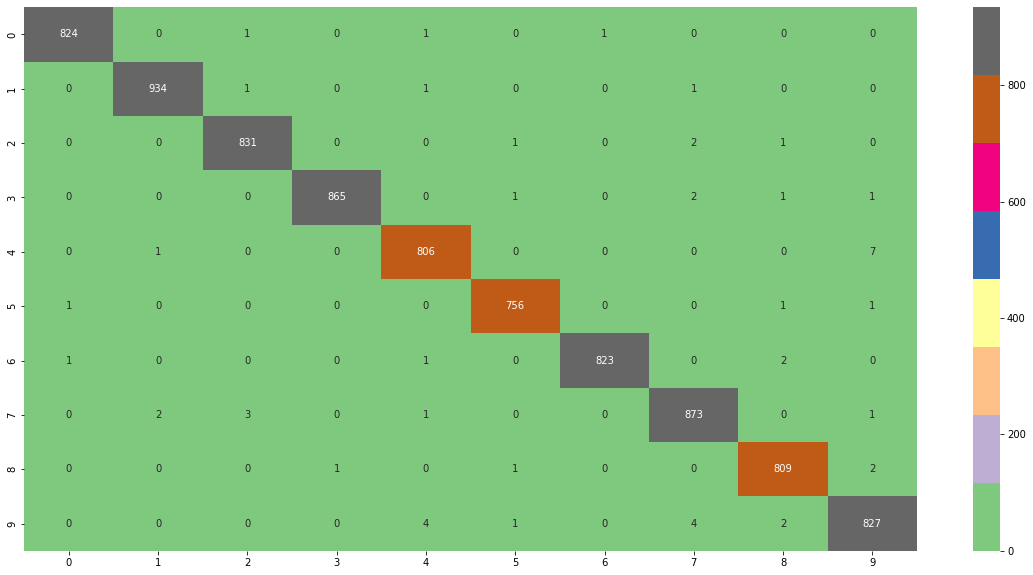

In [14]:
fig, axes = plt.subplots(figsize=(20, 10))
sns.heatmap(confusion_matrix(y_valid,np.argmax(y_pred,axis=1)), cmap="Accent", annot=True, fmt="g", ax=axes)
plt.show()

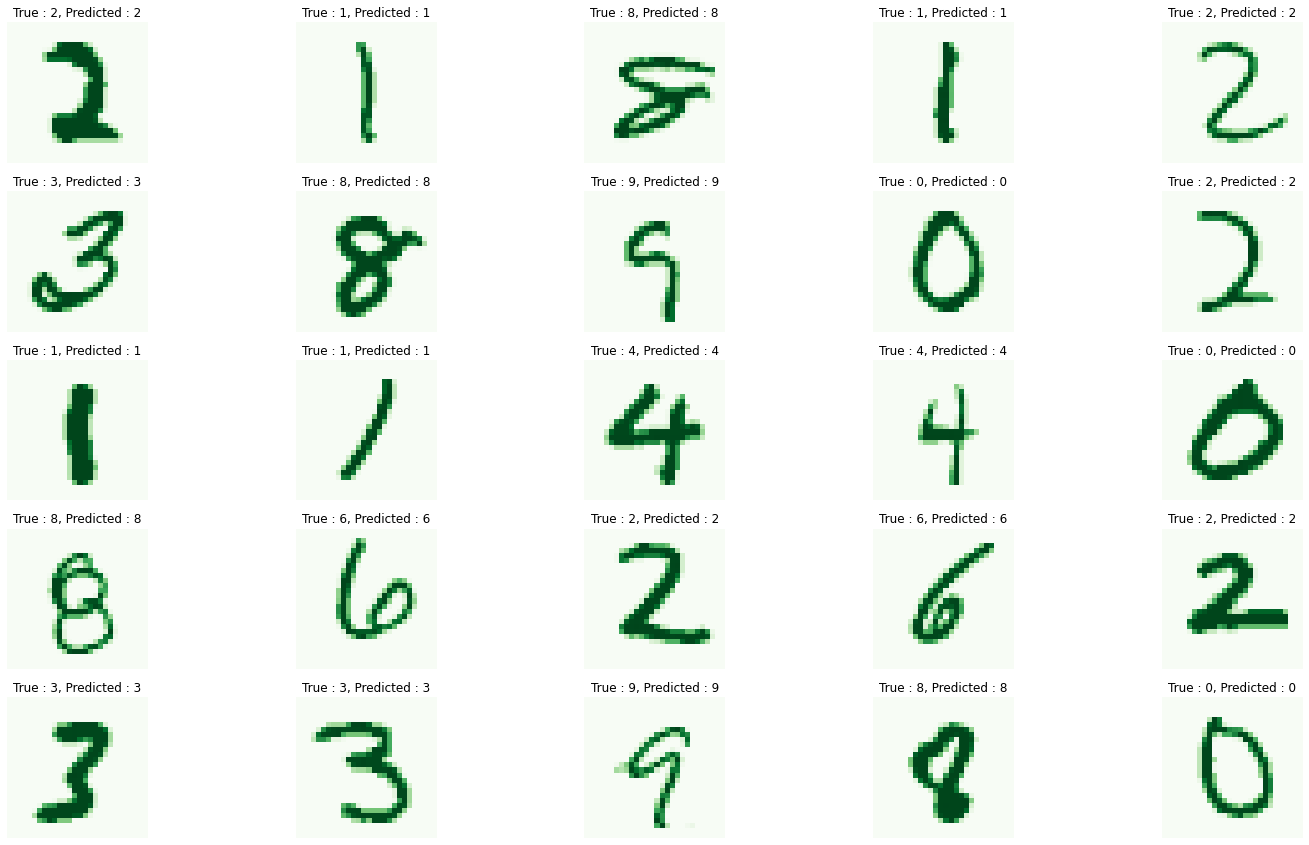

In [15]:
ROWS = 5
COLS = 5
images, labels = get_sample(ROWS*COLS,X_valid,y_valid)
fig, ax = plt.subplots(ROWS,COLS, figsize=(COLS*5,ROWS*3))
for i, (image,label) in enumerate(zip(images,labels)):
    pred_img = np.argmax(model.predict((image).reshape(-1,28,28,1)))
    if pred_img==label:
      cmap = "Greens"
    else:
      cmap = "Reds"
    ax[i//COLS, i%COLS].imshow(image*255, cmap=cmap)
    ax[i//COLS, i%COLS].axis('off')
    ax[i//COLS, i%COLS].set_title(f"True : {label}, Predicted : {pred_img}")
plt.show()

# Predictions

In [16]:
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
X_test = (test_df.values/255).reshape(-1,28,28,1)

In [17]:
y_test = np.argmax(model.predict(X_test),axis=1)
idxs = np.arange(1,X_test.shape[0]+1)

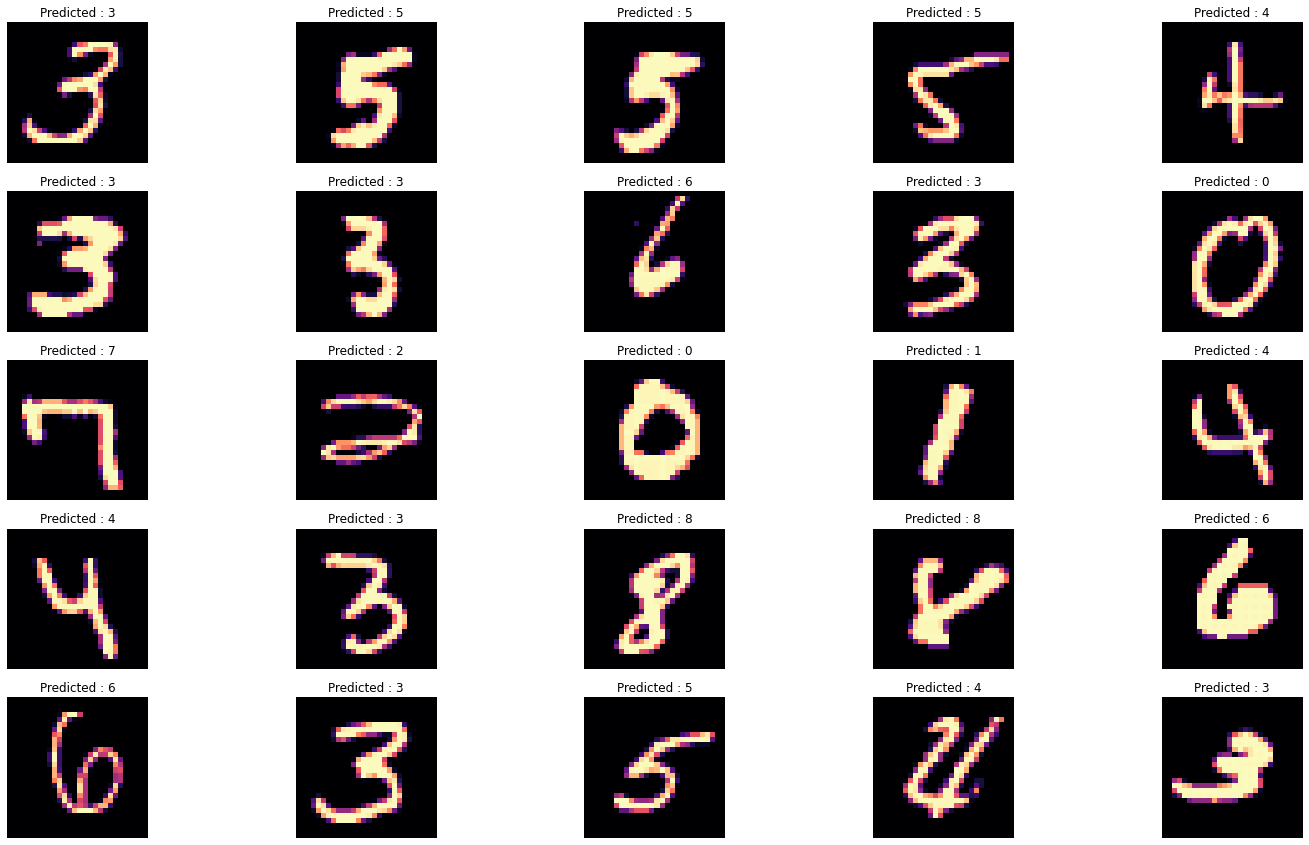

In [18]:
ROWS = 5
COLS = 5
images, labels = get_sample(ROWS*COLS,X_test,y_test)
fig, ax = plt.subplots(ROWS,COLS, figsize=(COLS*5,ROWS*3))
for i, (image,label) in enumerate(zip(images,labels)):
    ax[i//COLS, i%COLS].imshow(image*255, cmap="magma")
    ax[i//COLS, i%COLS].axis('off')
    ax[i//COLS, i%COLS].set_title(f"Predicted : {label}")
plt.show()

In [19]:
submission = pd.DataFrame({'ImageId': idxs, 'Label': y_test}, columns=['ImageId', 'Label'])
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [20]:
submission.to_csv("submission.csv",index=False)

##### Please leave an Upvote if you like this notebook!

# *Thanks*